# Sinusoidal 
This notebook intends to demo inference in a univariate model defined as
\begin{equation}
    \begin{cases}
        Y_t = X_t + \beta W_t, \\
        \mathrm{d}X_t = \sin(X_t - \alpha) \mathrm{d}t + \sigma\mathrm{d}V_t, \\
        X_0 \sim \mathcal{N}(0, \sigma),
    \end{cases}
\end{equation}
where $\alpha, \beta, \sigma > 0$. We begin importing necessary packages for defining the model and get (using Euler-Maruyama)

In [1]:
from pyfilter.timeseries import StateSpaceModel, EulerMaruyma, Observable

Next, we define a model where we let $(\beta, \alpha, \sigma) \triangleq (0.6, \pi, 1)$.

In [2]:
import numpy as np
from pyfilter.distributions.continuous import Gamma, Normal


def fh0(alpha, sigma):
    return 0


def gh0(alpha, sigma):
    return sigma


def fh(x, alpha, sigma):
    return np.sin(x - alpha)


def gh(x, alpha, sigma):
    return sigma


def go(x, beta):
    return x


def fo(x, beta):
    return beta

sinus = EulerMaruyma((fh0, gh0), (fh, gh), (np.pi, 1), (Normal(), Normal()))
obs = Observable((go, fo), (0.6,), Normal())

simmodel = StateSpaceModel(sinus, obs)

In order to perform inference, we sample some data and get

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(18, 16))

predictions = 40

x, y = simmodel.sample(2000 + predictions)

ax.plot(y, label='Observable')
ax.plot(x, 'r--', alpha=0.75, label='Hidden')

plt.legend()

We then define a model again where we set the priors to use

In [4]:
sinus = EulerMaruyma((fh0, gh0), (fh, gh), (Gamma(4), Gamma(4)), (Normal(), Normal()))
obs = Observable((go, fo), (Gamma(4),), Normal())

ssm = StateSpaceModel(sinus, obs)

Next, we choose the inference algorithm. As the observed noise process is additive in terms of the noise, we choose the UKF to target the state, and NESS to target the parameters.

In [5]:
from pyfilter.filters import NESS, UKF
import time

start = time.time()
alg = NESS(ssm, (1000,), filt=UKF).initialize().longfilter(y[:-predictions])
print('Took {:.0f} seconds to parse {:d} observations'.format(time.time() - start, len(y)))

Took 9 seconds to parse 2040 observations


Next, we plot the filtered component on the actual

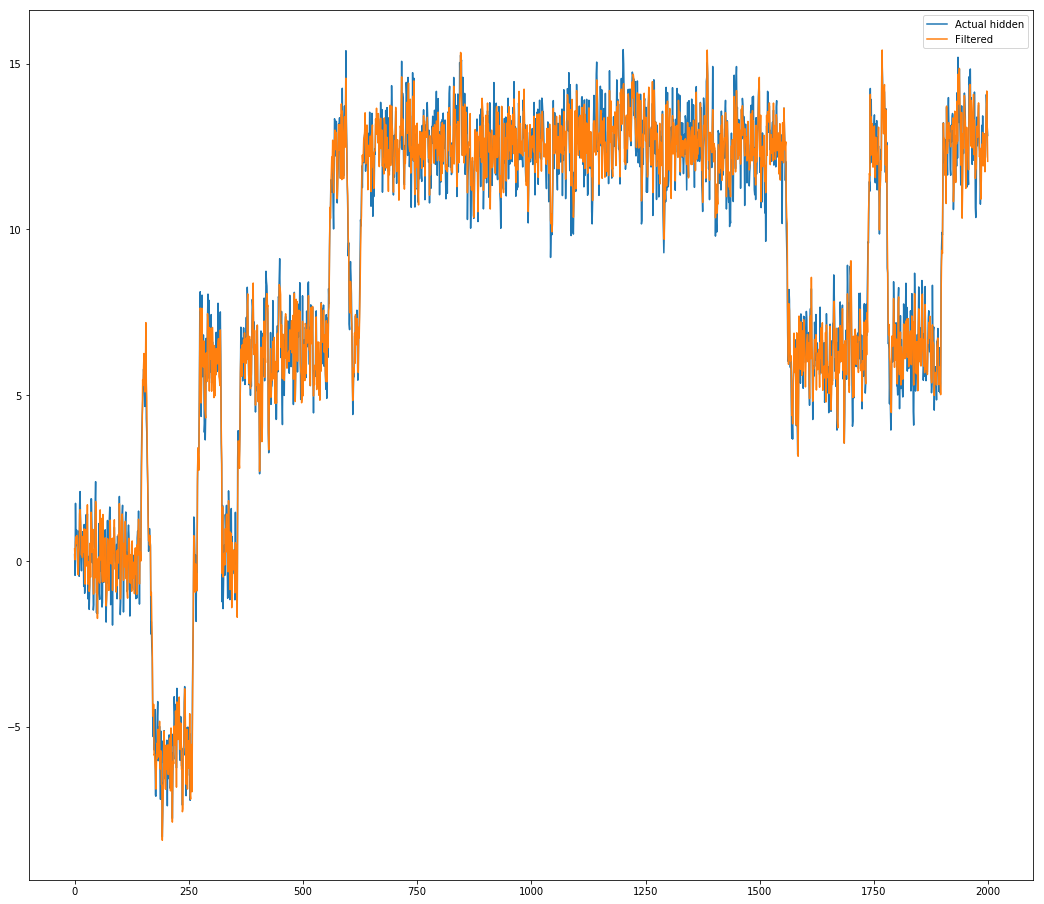

In [6]:
fig, ax = plt.subplots(figsize=(18, 16))

ax.plot(x[:-predictions], label='Actual hidden')
ax.plot(alg.filtermeans(), label='Filtered')

plt.legend()

We then plot the true parameters with the posteriors.

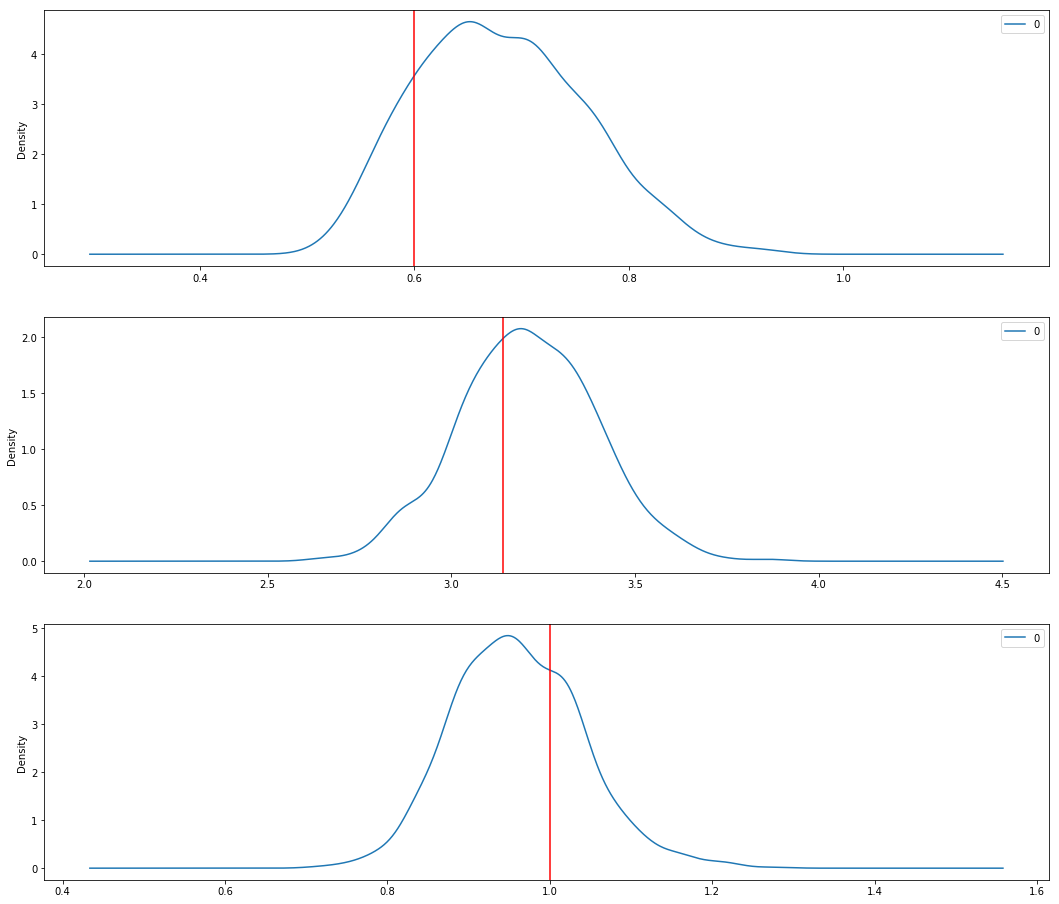

In [7]:
import pandas as pd


fig, ax = plt.subplots(3, figsize=(18, 16))

pd.DataFrame(alg.ssm.observable.theta[-1]).plot(kind='kde', ax=ax[0])
ax[0].axvline(simmodel.observable.theta[-1], color='r')

for i, (p, ptrue) in enumerate(zip(alg.ssm.hidden.theta, simmodel.hidden.theta)):
    pd.DataFrame(p).plot(kind='kde', ax=ax[i+1])
    ax[i+1].axvline(ptrue, color='r')

plt.show()